# **IMPORTANDO E ANALISANDO OS DADOS**

In [252]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split

# desabilita os warnings
import warnings
warnings.filterwarnings('ignore')

In [253]:
df = pd.read_csv("StudentsPerformance.csv")
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


**Verificando se há dados nulos:**

In [254]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB


In [255]:
df.isna().sum()

gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64

In [256]:
df.nunique()

gender                          2
race/ethnicity                  5
parental level of education     6
lunch                           2
test preparation course         2
math score                     81
reading score                  72
writing score                  77
dtype: int64

**Verificando se há dados duplicados:**

In [257]:
df.duplicated().sum()

0

**Vamos criar uma coluna de média das notas que servirá como target:**

In [258]:
curso_notas = df[["test preparation course", "math score", "reading score", "writing score"]]
df_notas = df[["math score", "reading score", "writing score"]]

In [259]:
lista_col = []
lista_media = []
for col in df_notas:
    lista_col.append(col)
for num in range(len(df_notas)):
  media = (df_notas[lista_col[0]].iloc[num] + df_notas[lista_col[1]].iloc[num] + df_notas[lista_col[2]].iloc[num])/3
  lista_media.append(media)
curso_notas["media"] = lista_media
df["media"] = lista_media
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


# **RANDOM FOREST**

## **Black Box**

In [21]:
from sklearn.compose import ColumnTransformer

from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder

from sklearn.impute import SimpleImputer

from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split

from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold

from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [17]:
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


In [31]:
#Separando o que é features e target:
X = df.drop(columns="media")
y = df["media"]

# Dividindo em dados de teste e dados de treino, peguei 20% para dados de teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# ==========================================================
# Tratamento das features numéricas
pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="median")),
                              ("std", StandardScaler())])

features_num = X_train.select_dtypes(include=np.number).columns.tolist()

# ==========================================================
# Tratando as features categóricas. Os valores nulos (NaN) serão preenchidos pelos dados mais constantes e posteriormente codificaremos todas elas com Ordinal Enconder. 

pipe_features_oe = Pipeline([("input_cat_oe", SimpleImputer(strategy="constant", fill_value="unknown")),
                            ("ordinal", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

features_oe = ["race/ethnicity", "parental level of education"]

# Tratando as features categóricas. Os valores nulos (NaN) serão preenchidos pelos dados mais constantes e posteriormente codificaremos todas elas com o One Hot Encoder. 

pipe_features_ohe = Pipeline([("input_cat_oe", SimpleImputer(strategy="constant", fill_value="unknown")),
                            ("onehot", OneHotEncoder(handle_unknown='ignore'))])

features_ohe = ["gender", "lunch", "test preparation course"]

# ==========================================================
# Pré-processador => Pegando as pipelines anteriores e unindo-as.
pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                     ("transf_oe", pipe_features_oe, features_oe),
                                     ("transf_ohe", pipe_features_ohe, features_ohe)])

# ==========================================================
# Pipeline final, usando o pré-processador e o estimador que queremos utilizar, neste caso o XGBoost para regressão.
pipe_rfr = Pipeline([("pre_processador", pre_processador),
                     ("rfr", RandomForestRegressor(random_state=42))])

# ==========================================================
#Vamos dividir em splits.
splitter = KFold(n_splits=5, random_state=42, shuffle=True)

#Motando a grade geral de parâmetros.
params_grid_rfr = {"rfr__n_estimators": [500, 1000],
                  "rfr__max_depth": [2, 3, 5],
                  "rfr__criterion": ["squared_error", "absolute_error", "poisson"],
                  "rfr__max_features": ["sqrt", "log2",]}

grid_rfr_edu = GridSearchCV(estimator=pipe_rfr,
                       param_grid=params_grid_rfr,
                       scoring="r2",
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1)

grid_rfr_edu.fit(X_train, y_train)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre_processador',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['math '
                                                                          'score',
                                                                          'reading '
                                                                          'score',
                   

In [32]:
grid_rfr_edu.best_params_

{'rfr__criterion': 'squared_error',
 'rfr__max_depth': 5,
 'rfr__max_features': 'sqrt',
 'rfr__n_estimators': 1000}

In [33]:
rfr_results = pd.DataFrame(grid_rfr_edu.cv_results_)
rfr_results.sort_values(by=["rank_test_score"])

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_rfr__criterion,param_rfr__max_depth,param_rfr__max_features,param_rfr__n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
9,2.219730,0.069684,0.166319,0.001767,squared_error,5,sqrt,1000,"{'rfr__criterion': 'squared_error', 'rfr__max_...",0.983699,0.985858,0.978537,0.979750,0.984830,0.982535,0.002878,1
11,2.188887,0.025917,0.166386,0.007370,squared_error,5,log2,1000,"{'rfr__criterion': 'squared_error', 'rfr__max_...",0.983699,0.985858,0.978537,0.979750,0.984830,0.982535,0.002878,1
8,1.099720,0.019686,0.092193,0.005568,squared_error,5,sqrt,500,"{'rfr__criterion': 'squared_error', 'rfr__max_...",0.982801,0.985465,0.977047,0.979324,0.984033,0.981734,0.003102,3
10,1.121642,0.021111,0.091668,0.004730,squared_error,5,log2,500,"{'rfr__criterion': 'squared_error', 'rfr__max_...",0.982801,0.985465,0.977047,0.979324,0.984033,0.981734,0.003102,3
23,5.244255,0.106575,0.145425,0.009708,absolute_error,5,log2,1000,"{'rfr__criterion': 'absolute_error', 'rfr__max...",0.979782,0.980910,0.972753,0.969543,0.982210,0.977040,0.004976,5
21,5.330561,0.033778,0.160176,0.012279,absolute_error,5,sqrt,1000,"{'rfr__criterion': 'absolute_error', 'rfr__max...",0.979782,0.980910,0.972753,0.969543,0.982210,0.977040,0.004976,5
20,2.649991,0.020169,0.093711,0.003846,absolute_error,5,sqrt,500,"{'rfr__criterion': 'absolute_error', 'rfr__max...",0.978832,0.980788,0.971347,0.969476,0.981509,0.976390,0.004995,7
22,2.651455,0.058643,0.082168,0.003340,absolute_error,5,log2,500,"{'rfr__criterion': 'absolute_error', 'rfr__max...",0.978832,0.980788,0.971347,0.969476,0.981509,0.976390,0.004995,7
5,2.093416,0.022174,0.159408,0.004721,squared_error,3,sqrt,1000,"{'rfr__criterion': 'squared_error', 'rfr__max_...",0.931457,0.939379,0.926772,0.905755,0.941183,0.928909,0.012708,9
7,2.062627,0.021500,0.164834,0.006796,squared_error,3,log2,1000,"{'rfr__criterion': 'squared_error', 'rfr__max_...",0.931457,0.939379,0.926772,0.905755,0.941183,0.928909,0.012708,9


In [26]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [34]:
# Predições de treino
y_pred_train = grid_rfr_edu.predict(X_train)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train, y_pred_train):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train)):.2f}")

# Predições de teste
y_pred_test = grid_rfr_edu.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test, y_pred_test):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test)):.2f}") 


Métricas de treino:

R^2: 0.99
MAE: 1.06
RMSE: 1.56

Métricas de teste:

R^2: 0.96
MAE: 1.40
RMSE: 2.77


In [35]:
import pickle

In [36]:
with open("grid_rfr_edu.pkl", "wb") as f:
    pickle.dump(grid_rfr_edu, f)

In [ ]:
with open("grid_rfr_edu.pkl", "rb") as f:
    
    grid_rfr_edu = pickle.load(f)

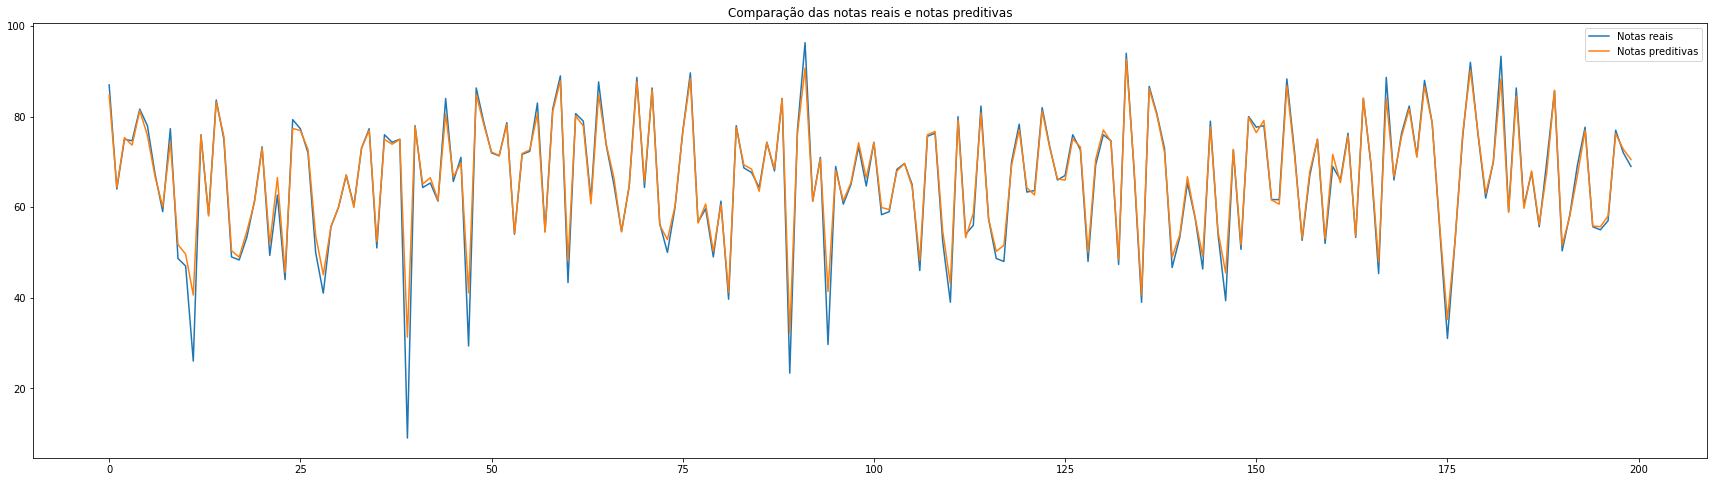

In [38]:
plt.figure(figsize=(30,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Notas reais")
plt.plot(x_ax, y_pred_test, label="Notas preditivas")
plt.title("Comparação das notas reais e notas preditivas")
plt.legend()
plt.show();

**Vamos criar uma tabela com a porcentagem de acertos para cada dado**

In [39]:
tabela_rfr = pd.DataFrame()

In [40]:
tabela_rfr["valores reais"] = y_test

In [41]:
tabela_rfr["valores preditos"] = y_pred_test

In [42]:
tabela_rfr

,valores reais,valores preditos
521,87.000000,84.760470
737,64.000000,64.386626
740,75.000000,75.361089
660,74.666667,73.706933
411,81.666667,81.348992
...,...,...
408,55.000000,55.677309
332,57.000000,58.054657
208,77.000000,76.201200
613,72.000000,72.805170


**Vamos criar uma tabela com a porcentagem de acertos para cada dado**

In [43]:
tabela_rfr = pd.DataFrame()

In [44]:
tabela_rfr["valores reais"] = y_test

In [45]:
tabela_rfr["valores preditos"] = y_pred_test

In [46]:
tabela_rfr["porcentagem de acerto %"]= (y_test/y_pred_test)*100

In [47]:
lista_num = []
for c in tabela_rfr["porcentagem de acerto %"]:
  if c > 100:
    num = abs(c - 200)
    lista_num.append(num)
  else:
    num = c
    lista_num.append(num)
  

tabela_rfr["porcentagem de acerto %"]= lista_num

In [48]:
tabela_rfr

,valores reais,valores preditos,porcentagem de acerto %
521,87.000000,84.760470,97.357814
737,64.000000,64.386626,99.399524
740,75.000000,75.361089,99.520855
660,74.666667,73.706933,98.697906
411,81.666667,81.348992,99.609492
...,...,...,...
408,55.000000,55.677309,98.783510
332,57.000000,58.054657,98.183337
208,77.000000,76.201200,98.951723
613,72.000000,72.805170,98.894076


## **Intervalo de confiança do Random Forest - Vamos simular intervalos para amostras com 30 e 100 dados:**

In [49]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import norm
from scipy import stats
from scipy.stats import t

In [126]:
df = pd.read_csv("StudentsPerformance.csv")

In [127]:
curso_notas = df[["test preparation course", "math score", "reading score", "writing score"]]
df_notas = df[["math score", "reading score", "writing score"]]

In [128]:
lista_col = []
lista_media = []
for col in df_notas:
    lista_col.append(col)
for num in range(len(df_notas)):
  media = (df_notas[lista_col[0]].iloc[num] + df_notas[lista_col[1]].iloc[num] + df_notas[lista_col[2]].iloc[num])/3
  lista_media.append(media)
curso_notas["media"] = lista_media
df["media"] = lista_media
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 dados diferentes.**

In [140]:
# ["race/ethnicity", "parental level of education"]
oe =  OrdinalEncoder()
oe.fit(df[["gender"]])


df["gender"] = oe.transform(df[["gender"]])

In [141]:
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,0.0,1.0,1.0,1.0,1.0,72,72,74,72.666667
1,0.0,2.0,4.0,1.0,0.0,69,90,88,82.333333
2,0.0,1.0,3.0,1.0,1.0,90,95,93,92.666667
3,1.0,0.0,0.0,0.0,1.0,47,57,44,49.333333
4,1.0,2.0,4.0,1.0,1.0,76,78,75,76.333333
...,...,...,...,...,...,...,...,...,...
995,0.0,4.0,3.0,1.0,0.0,88,99,95,94.000000
996,1.0,2.0,2.0,0.0,1.0,62,55,55,57.333333
997,0.0,2.0,2.0,0.0,0.0,59,71,65,65.000000
998,0.0,3.0,4.0,1.0,0.0,68,78,77,74.333333


**Vamos escalonar todas as Features, pois a amplitude entre os dados está muito grande, isso pode causar um viés no resultado final:**

In [117]:
df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score', 'media'],
      dtype='object')

In [143]:
ssc = StandardScaler()

ssc.fit(df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score','writing score']])
h= ssc.transform(df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']])
df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']] = h

In [147]:
#Separando o que é features e target:
X = df.drop(columns="media")
y = df["media"]

In [148]:
X = np.array(X)

**Com 30 e 100 amostras**

In [149]:
resultados_rf_cv_30 = []
resultados_rf_cv_100 = []
for i in range(10):
  kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
  
  rf = RandomForestRegressor()
  scores = cross_val_score(rf, X, y, cv = kfold)
  resultados_rf_cv_100.append(scores)
  resultados_rf_cv_30.append(scores.mean())

In [150]:
scores

array([0.99766806, 0.99748428, 0.99802622, 0.99734551, 0.99804682,
       0.99648377, 0.99606424, 0.98912301, 0.99752889, 0.99768799])

In [151]:
resultados_rf_cv_30 = np.array(resultados_rf_cv_30)
resultados_rf_cv_100 = np.array(np.asarray(resultados_rf_cv_100).reshape(-1))

In [152]:
len(resultados_rf_cv_30)

10

**Para 30 amostras usamos o t-student:**

In [153]:
intervalos_rf_t = t.interval(0.95, len(resultados_rf_cv_30) - 1, 
                                    resultados_rf_cv_30.mean(), 
                                    stats.sem(resultados_rf_cv_30, ddof = 0))
intervalos_rf_t

(0.9967359074332951, 0.9969447885358687)

**Variação do intervalo:**

In [154]:
abs(resultados_rf_cv_30.mean() - intervalos_rf_t[1])

0.00010444055128677743

In [156]:
print(f"Temos 95% de confiança de que a média de acertos do Random Forest com 30 amostras está no intervalo entre {intervalos_rf_t[0]*100:.2f} % e {intervalos_rf_t[1]*100:.2f} %")

Temos 95% de confiança de que a média de acertos do Random Forest com 30 amostras está no intervalo entre 99.67 % e 99.69 %


**Média do score:**

In [155]:
pd.DataFrame(resultados_rf_cv_30).mean()[0]

0.9968403479845819



---



**Para 100 amostras**

In [162]:
intervalos_rf_n = norm.interval(0.95, resultados_rf_cv_100.mean(), 
                                       stats.sem(resultados_rf_cv_100))
intervalos_rf_n

(0.9964209186957352, 0.9972597772734287)

**Para 100 amostras ele acabou aumentando a margem de erro em relação ao de 30 amostras, o que é esperado.**

**Variação do intervalo:**

In [158]:
abs(resultados_rf_cv_100.mean() - intervalos_rf_n[1])

0.000419429288846751

In [159]:
print(f"Temos 95% de confiança de que a média de acertos do Random Forest com 90 amostras está no intervalo entre {intervalos_rf_n[0]*100:.2f}% e {intervalos_rf_n[1]*100:.2f}%")

Temos 95% de confiança de que a média de acertos do Random Forest com 90 amostras está no intervalo entre 99.64% e 99.73%


**Média do score:**

In [163]:
resultado_100 = resultados_rf_cv_100
resultado_100 = (resultado_100[0] + resultado_100[1] + resultado_100[2])/3
resultado_100

0.9980300803467271

# **XGBOOST**

## **Black Box**

In [164]:
from xgboost import XGBRegressor

In [287]:
#Separando o que é features e target:
X = df.drop(columns="media")
y = df["media"]

# Dividindo em dados de teste e dados de treino, peguei 20% para dados de teste:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Iniciando a construção da Pipeline:
# ==========================================================
#Primeiro vamos tratar as features numéricas. Tratando os valores nulos (NaN) e escalonando já que a variância entre as features é grande.
pipe_features_num = Pipeline([("input_num", SimpleImputer(strategy="mean")),
                              ("std", StandardScaler())])

features_num = X_train.select_dtypes(include=np.number).columns.tolist()
# ==========================================================
# ==========================================================
# Tratando as features categóricas. Os valores nulos (NaN) serão preenchidos pelos dados mais constantes e posteriormente codificaremos todas elas com Ordinal Enconder. 

pipe_features_oe = Pipeline([("input_cat_oe", SimpleImputer(strategy="constant", fill_value="unknown")),
                            ("ordinal", OrdinalEncoder())])

features_oe = ["race/ethnicity", "parental level of education"]

# Tratando as features categóricas. Os valores nulos (NaN) serão preenchidos pelos dados mais constantes e posteriormente codificaremos todas elas com o One Hot Encoder. 

pipe_features_ohe = Pipeline([("input_cat_oe", SimpleImputer(strategy="constant", fill_value="unknown")),
                            ("onehot", OneHotEncoder(handle_unknown='ignore'))])

features_ohe = ["gender", "lunch", "test preparation course"]
# ==========================================================
# Pré-processador => Pegando as pipelines anteriores e unindo-as.
pre_processador = ColumnTransformer([("transf_num", pipe_features_num, features_num),
                                     ("transf_cat", pipe_features_oe, features_oe)])

# ==========================================================
# Pipeline final, usando o pré-processador e o estimador que queremos utilizar, neste caso o XGBoost para regressão.
pipe_xgbr = Pipeline([("pre_processador", pre_processador),
                     ("xgbr", XGBRegressor(eval_metric='logloss', random_state=42))])

# ==========================================================
#Vamos dividir em splits para ter mais variedade no processamento dos dados.
splitter = KFold(n_splits=5, random_state=42, shuffle=True)

#Montando a grade de parâmetros do estimador (XGBoost)
params_grid_xgbr = {"xgbr__n_estimators": [1000],
                   "xgbr__max_depth": [2],
                   "xgbr__learning_rate": [0.001, 0.01],
                   "xgbr__colsample_bytree": [0.5],
                   "xgbr__subsample": [0.5]}


#Motando a grade geral de parâmetros.
grid_xgbr_edu = GridSearchCV(estimator=pipe_xgbr,
                       param_grid=params_grid_xgbr,
                       scoring="r2",
                       cv=splitter,
                       verbose=10,
                       n_jobs=-1)

grid_xgbr_edu.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[23:54:35] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('pre_processador',
                                        ColumnTransformer(transformers=[('transf_num',
                                                                         Pipeline(steps=[('input_num',
                                                                                          SimpleImputer()),
                                                                                         ('std',
                                                                                          StandardScaler())]),
                                                                         ['math '
                                                                          'score',
                                                                          'reading '
                                                                          'score',
                                    

In [265]:
grid_xgbr_edu.best_params_

{'xgbr__colsample_bytree': 0.5,
 'xgbr__learning_rate': 0.01,
 'xgbr__max_depth': 2,
 'xgbr__n_estimators': 750,
 'xgbr__subsample': 0.5}

In [ ]:
xgbr_results = pd.DataFrame(grid_xgbr_edu.cv_results_)
xgbr_results.sort_values(by=["rank_test_score"])

In [288]:
# Predições de treino
y_pred_train_xgbr = grid_xgbr_edu.predict(X_train)

print("\nMétricas de treino:\n")
print(f"R^2: {r2_score(y_train, y_pred_train_xgbr):.2f}")
print(f"MAE: {mean_absolute_error(y_train, y_pred_train_xgbr):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_train, y_pred_train_xgbr)):.2f}")

# Predições de teste
y_pred_test_xgbr = grid_xgbr_edu.predict(X_test)

print("\nMétricas de teste:\n")
print(f"R^2: {r2_score(y_test, y_pred_test_xgbr):.2f}")
print(f"MAE: {mean_absolute_error(y_test, y_pred_test_xgbr):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred_test_xgbr)):.2f}") 


Métricas de treino:

R^2: 1.00
MAE: 0.28
RMSE: 0.36

Métricas de teste:

R^2: 1.00
MAE: 0.37
RMSE: 0.98




---



**Nos dois gráficos abaixos percebemos que os dados de treinos não gabaritaram(não gravaram a resposta) e, sim, geraram erros extremamentes pequenos. Isso se dá pela coesão dos dados. Podemos ver pela MAE, se houvesse gabaritado as respostas os dados de treino não gerariam erros.**

Peguei um exemplo:

In [285]:
df.iloc[[0]]

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667


In [286]:
grid_xgbr_edu.predict(df.iloc[[0]])


array([72.32931], dtype=float32)



---



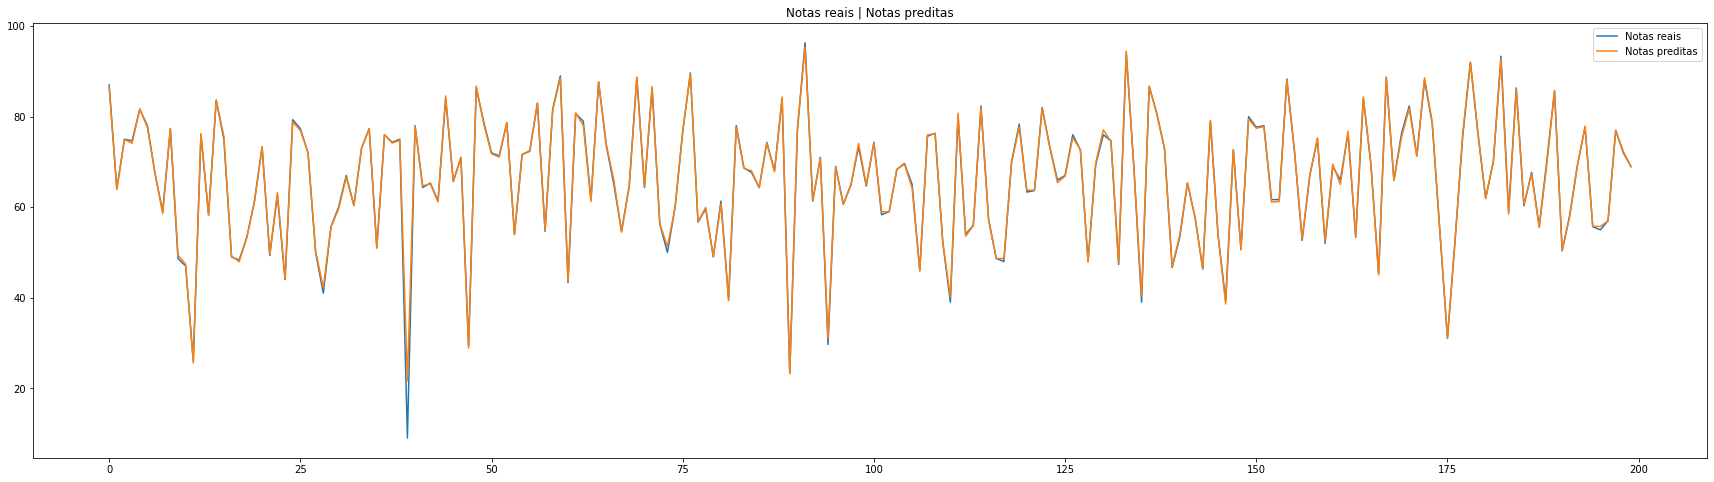

In [289]:
plt.figure(figsize=(30,8))
x_ax = range(len(y_test))
plt.plot(x_ax, y_test, label="Notas reais")
plt.plot(x_ax, y_pred_test_xgbr, label="Notas preditas")
plt.title("Notas reais | Notas preditas")
plt.legend()
plt.show();

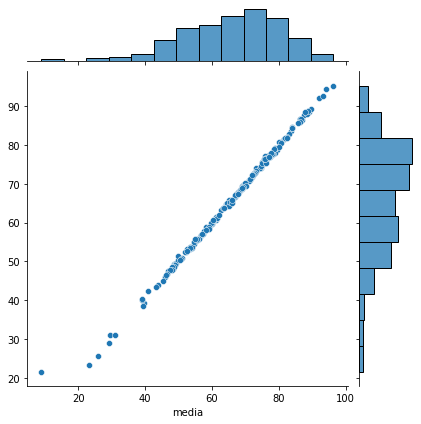

In [290]:
sns.jointplot(y_test, y_pred_test_xgbr)
plt.xlabel("Valores reais")
plt.ylabel("Valores preditos");

In [183]:
import pickle

In [291]:
with open("grid_xgbr_edu.pkl", "wb") as f:
    pickle.dump(grid_xgbr_edu, f)

In [ ]:
with open("grid_xgbr_edu.pkl", "rb") as f:
    
    grid_xgbr_edu = pickle.load(f)

In [292]:
y_pred_test_xgbr

array([86.43401 , 63.975212, 74.9161  , 74.1171  , 81.62404 , 77.62861 ,
       67.45434 , 58.56926 , 77.37108 , 49.378216, 47.44185 , 25.596128,
       76.26674 , 58.205875, 83.57543 , 75.67952 , 49.215237, 47.94231 ,
       53.320015, 61.195553, 73.28362 , 49.557243, 63.20088 , 44.039562,
       78.80646 , 76.95851 , 72.08979 , 50.24466 , 42.28255 , 55.61765 ,
       59.578964, 66.597435, 60.44963 , 73.007416, 77.319824, 50.952896,
       75.985985, 74.15617 , 74.77001 , 21.604841, 77.834435, 64.707695,
       65.13118 , 61.12859 , 84.56068 , 65.78836 , 71.00157 , 28.853724,
       86.76769 , 78.23941 , 71.78814 , 71.06359 , 78.67896 , 53.909847,
       71.61463 , 72.51139 , 82.92756 , 54.95746 , 81.48356 , 88.5183  ,
       43.48545 , 80.81788 , 78.044464, 61.232388, 87.67673 , 73.92513 ,
       65.92124 , 54.473225, 64.423225, 88.68446 , 64.57158 , 86.627144,
       56.365288, 51.351177, 59.864357, 76.7633  , 89.44547 , 56.820892,
       59.935513, 49.057117, 60.730316, 39.35679 , 

In [293]:
y_test.values

array([87.        , 64.        , 75.        , 74.66666667, 81.66666667,
       78.        , 67.33333333, 59.        , 77.33333333, 48.66666667,
       47.        , 26.        , 76.        , 58.33333333, 83.66666667,
       75.        , 49.        , 48.33333333, 53.33333333, 61.33333333,
       73.33333333, 49.33333333, 62.66666667, 44.        , 79.33333333,
       77.33333333, 72.        , 50.        , 41.        , 55.66666667,
       60.        , 67.        , 60.33333333, 73.        , 77.33333333,
       51.        , 76.        , 74.33333333, 75.        ,  9.        ,
       78.        , 64.33333333, 65.33333333, 61.33333333, 84.        ,
       65.66666667, 71.        , 29.33333333, 86.33333333, 78.66666667,
       72.        , 71.33333333, 78.66666667, 54.        , 71.66666667,
       72.33333333, 83.        , 54.66666667, 81.66666667, 89.        ,
       43.33333333, 80.66666667, 79.        , 61.66666667, 87.66666667,
       73.66666667, 65.        , 54.66666667, 64.66666667, 88.66

**Vamos criar uma tabela com a porcentagem de acertos para cada dado**

In [294]:
tabela_xgbr = pd.DataFrame()

In [295]:
tabela_xgbr["valores reais"] = y_test

In [296]:
tabela_xgbr["valores preditos"] = y_pred_test_xgbr

In [297]:
tabela_xgbr["porcentagem de acerto %"]= (y_test/y_pred_test_xgbr)*100

In [298]:
lista_num = []
for c in tabela_xgbr["porcentagem de acerto %"]:
  if c > 100:
    num = abs(c - 200)
    lista_num.append(num)
  else:
    num = c
    lista_num.append(num)
  

tabela_xgbr["porcentagem de acerto %"]= lista_num

In [299]:
tabela_xgbr

,valores reais,valores preditos,porcentagem de acerto %
521,87.000000,86.434013,99.345181
737,64.000000,63.975212,99.961254
740,75.000000,74.916100,99.888007
660,74.666667,74.117104,99.258521
411,81.666667,81.624039,99.947775
...,...,...,...
408,55.000000,55.749546,98.655512
332,57.000000,56.988865,99.980461
208,77.000000,76.928085,99.906517
613,72.000000,72.309021,99.572638


## **Intervalo de confiança do XGBoost - Vamos simular intervalos para amostras com 30 e 100 dados:**

In [300]:
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score, KFold
from scipy.stats import norm
from scipy import stats
from scipy.stats import t

In [303]:
df = pd.read_csv("StudentsPerformance.csv")

In [304]:
curso_notas = df[["test preparation course", "math score", "reading score", "writing score"]]
df_notas = df[["math score", "reading score", "writing score"]]

In [305]:
lista_col = []
lista_media = []
for col in df_notas:
    lista_col.append(col)
for num in range(len(df_notas)):
  media = (df_notas[lista_col[0]].iloc[num] + df_notas[lista_col[1]].iloc[num] + df_notas[lista_col[2]].iloc[num])/3
  lista_media.append(media)
curso_notas["media"] = lista_media
df["media"] = lista_media
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 dados diferentes.**

In [314]:
oe =  OrdinalEncoder()
oe.fit(df[["test preparation course"]])

df["test preparation course"] = oe.transform(df[["test preparation course"]])

**Vamos escalonar todas as Features, pois a amplitude entre os dados está muito grande, isso pode causar um viés no resultado final:**

In [ ]:
df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score', 'media'],
      dtype='object')

In [316]:
ssc = StandardScaler()

ssc.fit(df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score','writing score']])
h= ssc.transform(df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']])
df[['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course', 'math score', 'reading score', 'writing score']] = h

In [317]:
#Separando o que é features e target:
X = df.drop(columns="media")
y = df["media"]

In [318]:
X = np.array(X)

**Com 30 e 90 amostras**

In [ ]:
resultados_xgbr_cv_30 = []
resultados_xgbr_cv_100 = []
for i in range(10):
  kfold = KFold(n_splits = 10, shuffle = True, random_state = i)
  
  xgbr = XGBRegressor()
  scores = cross_val_score(xgbr, X, y, cv = kfold)
  resultados_xgbr_cv_100.append(scores)
  resultados_xgbr_cv_30.append(scores.mean())

In [320]:
scores

array([0.99774387, 0.99846307, 0.99790529, 0.99780912, 0.99820824,
       0.99843955, 0.99817466, 0.99177369, 0.99768445, 0.99584223])

In [321]:
resultados_xgbr_cv_30 = np.array(resultados_xgbr_cv_30)
resultados_xgbr_cv_100 = np.array(np.asarray(resultados_xgbr_cv_100).reshape(-1))

In [322]:
len(resultados_rf_cv_30)

10

**Para 30 amostras usamos o t-student:**

In [323]:
intervalos_xgbr_t = t.interval(0.95, len(resultados_xgbr_cv_30) - 1, 
                                    resultados_xgbr_cv_30.mean(), 
                                    stats.sem(resultados_xgbr_cv_30, ddof = 0))
intervalos_xgbr_t

(0.9973661237090807, 0.9975139670780697)

**Variação do intervalo:**

In [324]:
abs(resultados_xgbr_cv_30.mean() - intervalos_xgbr_t[1])

7.392168449449343e-05

In [325]:
print(f"Temos 95% de confiança de que a média de acertos do XGBoost com 30 amostras está no intervalo entre {intervalos_xgbr_t[0]*100:.2f} % e {intervalos_xgbr_t[1]*100:.2f} %")

Temos 95% de confiança de que a média de acertos do XGBoost com 30 amostras está no intervalo entre 99.74 % e 99.75 %


**Média do score:**

In [326]:
pd.DataFrame(resultados_xgbr_cv_30).mean()[0]

0.9974400453935752



---



**Para 100 amostras**

In [327]:
intervalos_xgbr_n = norm.interval(0.95, resultados_xgbr_cv_100.mean(), 
                                       stats.sem(resultados_xgbr_cv_100))
intervalos_xgbr_n

(0.9971194046112308, 0.9977606861759198)

**Para 100 amostras ele acabou aumentando a margem de erro em relação ao de 30 amostras, o que é esperado.**

**Variação do intervalo:**

In [328]:
abs(resultados_xgbr_cv_100.mean() - intervalos_xgbr_n[1])

0.00032064078234450566

In [329]:
print(f"Temos 95% de confiança de que a média de acertos do XGBoost com 90 amostras está no intervalo entre {intervalos_xgbr_n[0]*100:.2f}% e {intervalos_xgbr_n[1]*100:.2f}%")

Temos 95% de confiança de que a média de acertos do XGBoost com 90 amostras está no intervalo entre 99.71% e 99.78%


**Média do score:**

In [330]:
resultado_100 = resultados_xgbr_cv_100
resultado_100 = (resultado_100[0] + resultado_100[1] + resultado_100[2])/3
resultado_100

0.9982290689381452

#**INTERPRETANDO O MODELO GLOBALMENTE**

**Para a interpretação só podemos considerar as features numéricas, vamos retirar as features categóricas:**

**SHAP**

In [ ]:
df

,Suburb,Address,Rooms,Type,Price,Method,SellerG,Date,Distance,Postcode,...,Bathroom,Car,Landsize,BuildingArea,YearBuilt,CouncilArea,Lattitude,Longtitude,Regionname,Propertycount
0,Abbotsford,85 Turner St,2,h,1480000.0,S,Biggin,3/12/2016,2.5,3067.0,...,1.0,1.0,202.0,NaN,NaN,Yarra,-37.7996,144.9984,Northern Metropolitan,4019.0
1,Abbotsford,25 Bloomburg St,2,h,1035000.0,S,Biggin,4/02/2016,2.5,3067.0,...,1.0,0.0,156.0,79.0,1900.0,Yarra,-37.8079,144.9934,Northern Metropolitan,4019.0
2,Abbotsford,5 Charles St,3,h,1465000.0,SP,Biggin,4/03/2017,2.5,3067.0,...,2.0,0.0,134.0,150.0,1900.0,Yarra,-37.8093,144.9944,Northern Metropolitan,4019.0
3,Abbotsford,40 Federation La,3,h,850000.0,PI,Biggin,4/03/2017,2.5,3067.0,...,2.0,1.0,94.0,NaN,NaN,Yarra,-37.7969,144.9969,Northern Metropolitan,4019.0
4,Abbotsford,55a Park St,4,h,1600000.0,VB,Nelson,4/06/2016,2.5,3067.0,...,1.0,2.0,120.0,142.0,2014.0,Yarra,-37.8072,144.9941,Northern Metropolitan,4019.0


In [337]:
df = pd.read_csv("StudentsPerformance.csv")
df.columns

Index(['gender', 'race/ethnicity', 'parental level of education', 'lunch',
       'test preparation course', 'math score', 'reading score',
       'writing score'],
      dtype='object')

In [338]:
curso_notas = df[["test preparation course", "math score", "reading score", "writing score"]]
df_notas = df[["math score", "reading score", "writing score"]]

In [339]:
lista_col = []
lista_media = []
for col in df_notas:
    lista_col.append(col)
for num in range(len(df_notas)):
  media = (df_notas[lista_col[0]].iloc[num] + df_notas[lista_col[1]].iloc[num] + df_notas[lista_col[2]].iloc[num])/3
  lista_media.append(media)
curso_notas["media"] = lista_media
df["media"] = lista_media
df.head()

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,female,group B,bachelor's degree,standard,none,72,72,74,72.666667
1,female,group C,some college,standard,completed,69,90,88,82.333333
2,female,group B,master's degree,standard,none,90,95,93,92.666667
3,male,group A,associate's degree,free/reduced,none,47,57,44,49.333333
4,male,group C,some college,standard,none,76,78,75,76.333333


**Transformando as Features categóricas em numéricas - OrdinalEncoder() - Feature com mais de 2 dados diferentes.**

In [356]:
oe =  OrdinalEncoder()
oe.fit(df[["gender"]])

df["gender"] = oe.transform(df[["gender"]])

In [355]:
df.head(2)

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score,media
0,female,1.0,1.0,1.0,1.0,72,72,74,72.666667
1,female,2.0,4.0,1.0,0.0,69,90,88,82.333333


In [357]:
X = df.drop(columns=["media"])
y = df["media"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=20)

In [ ]:
!pip install shap
import shap

In [358]:
xgbr = XGBRegressor().fit(X_train, y_train)

[00:10:18] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [359]:
explainer = shap.TreeExplainer(xgbr)

In [360]:
shap_vals = explainer.shap_values(X_train)

**Temos abaixo as Features que mais impactaram na escolha dos valores preditivos para todos os dados:**

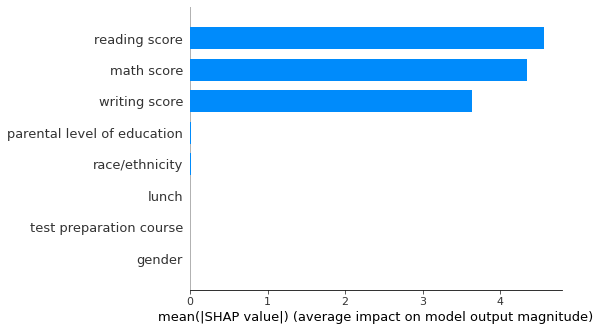

In [361]:
shap.summary_plot(shap_vals, X_train, plot_type="bar")